In [1]:
import sys
import ssl
import urllib.request
from io import StringIO

from copy import deepcopy
import os
from os import getcwd
from os.path import dirname, join
from sklearn.neighbors import KNeighborsRegressor
from scipy.optimize import minimize, basinhopping


import datetime
from sklearn import preprocessing



import csv
import json

# Load Json File
# Load the arguments
with open('arguments.json', 'r') as fid:
    arguments = json.load(fid)




import matplotlib.pyplot as plt
import numpy as np
import scipy 
import pandas as pd
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d

SRC_DIR = 'mammal/MAMMAL' # relative path to MAMMAL library 
sys.path.append(SRC_DIR)
BASE_DIR = getcwd() # get current directory with files
DATA_DIR = join(BASE_DIR, arguments['data_dir'])
TEST_DIR = join(DATA_DIR, 'test') # directory with intermagnet data
EXAM_DIR = join(DATA_DIR, 'diurnal_test_data') # second day intermagnet data to test parameters

import Diurnal
from Parse import parseIM as pi
from Utils import ProcessingUtils as pu
from Utils import Filters as filt

# Create Output CSV File
out_file = open(arguments['csv_file'], mode = 'a', encoding='UTF8')

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 10) # (w, h)#

# Determine Day Ranges for Training and Testing Data Sets

In [2]:
obj = os.walk(TEST_DIR)
date_names = []
file_names = []
for _, _, files in obj:
    for file in files:
        if(file[16:] == 'min'):
            file_names.append(file[3:11])

x = sorted(file_names)
#print(x)
start_tra = x[0]
end_tra = x[len(x)-1]

# Do It again for Testing Data 
obj = os.walk(EXAM_DIR)
date_names = []
file_names = []
for _, _, files in obj:
    for file in files:
        if(file[16:] == 'min'):
            file_names.append(file[3:11])

x = sorted(file_names)
#print(x)
start_tst = x[0]
end_tst = x[len(x)-1]

# Load INTERMAGNET Data

/home/antuser/anaconda3/envs/envp39/lib/python3.9/site-packages/pandas-1.3.4-py3.9-linux-x86_64.egg/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Loaded bou20230330qmin.min
Loaded frd20230330qmin.min
Loaded bou20230328qmin.min
Loaded frd20230328qmin.min
Loaded frd20230403qmin.min
Loaded bou20230403qmin.min
Loaded bou20230402qmin.min
Loaded frd20230402qmin.min
Loaded frd20230331qmin.min
Loaded bou20230331qmin.min
Loaded frd20230401qmin.min
Loaded bou20230401qmin.min
Loaded bou20230404qmin.min
Loaded frd20230404qmin.min
Loaded frd20230329qmin.min
Loaded bou20230329qmin.min
Loaded bou20230405qmin.min
Loaded frd20230405qmin.min
Loaded bou20230327qmin.min
Loaded frd20230327qmin.min


100%|██████████████████████████████████████████| 72/72 [00:00<00:00, 131.53it/s]


            DATE     TIME  DOY        X       Y        Z         F  \
0     2023-03-27      0.0   86  20489.2  2899.1  47102.3  51460.74   
1     2023-03-27     60.0   86  20489.3  2899.4  47102.3  51460.79   
2     2023-03-27    120.0   86  20489.4  2899.5  47102.4  51460.93   
3     2023-03-27    180.0   86  20489.2  2899.6  47102.4  51460.96   
4     2023-03-27    240.0   86  20489.3  2899.8  47102.4  51461.01   
...          ...      ...  ...      ...     ...      ...       ...   
1435  2023-04-05  86100.0   95  20510.3  2886.5  47094.4  51459.20   
1436  2023-04-05  86160.0   95  20510.2  2886.7  47094.5  51459.17   
1437  2023-04-05  86220.0   95  20510.2  2886.8  47094.6  51459.26   
1438  2023-04-05  86280.0   95  20510.2  2886.9  47094.6  51459.27   
1439  2023-04-05  86340.0   95  20510.3  2887.1  47094.6  51459.22   

                datetime     epoch_sec     LAT     LONG     ALT        IGRF_X  \
0    2023-03-27 00:00:00  1.679875e+09  40.137 -105.236  1682.0  20530.229197 

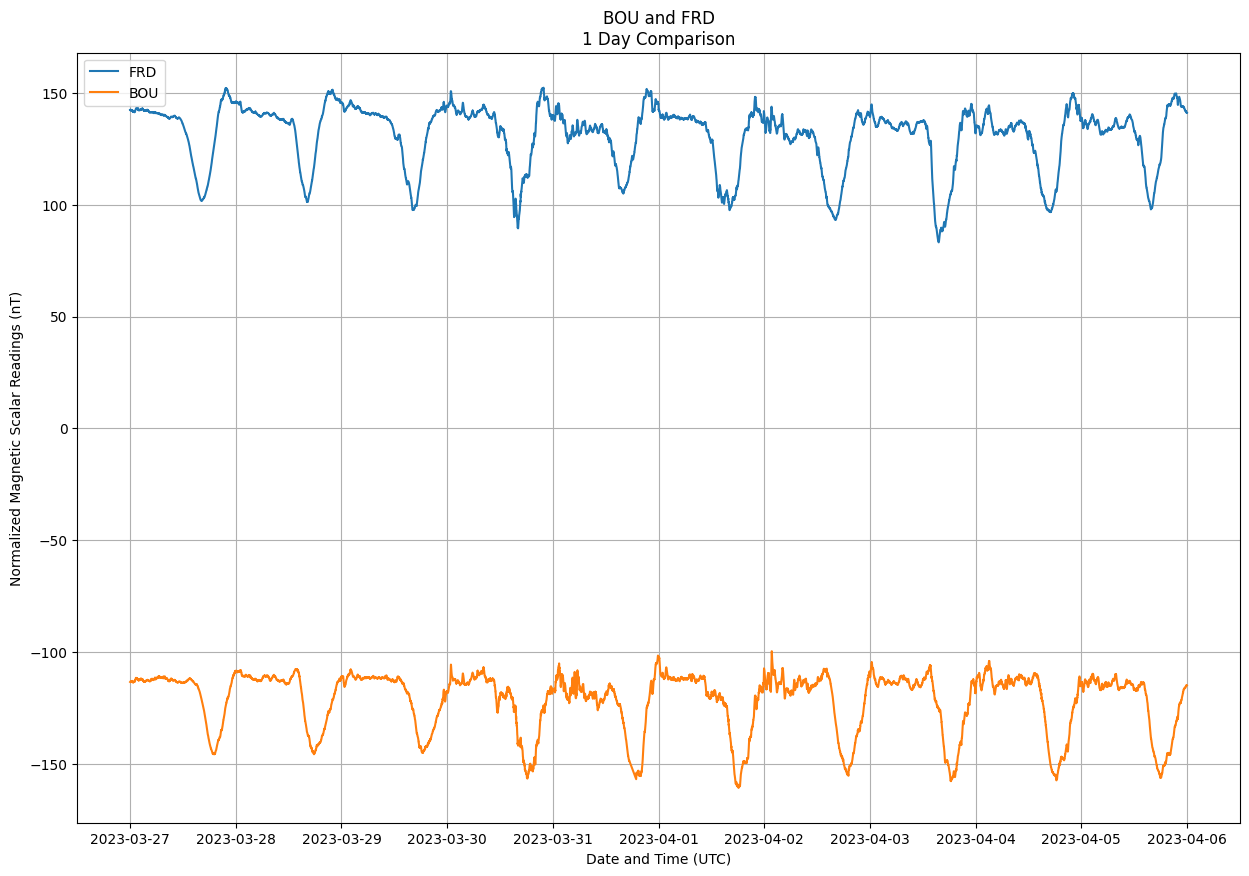

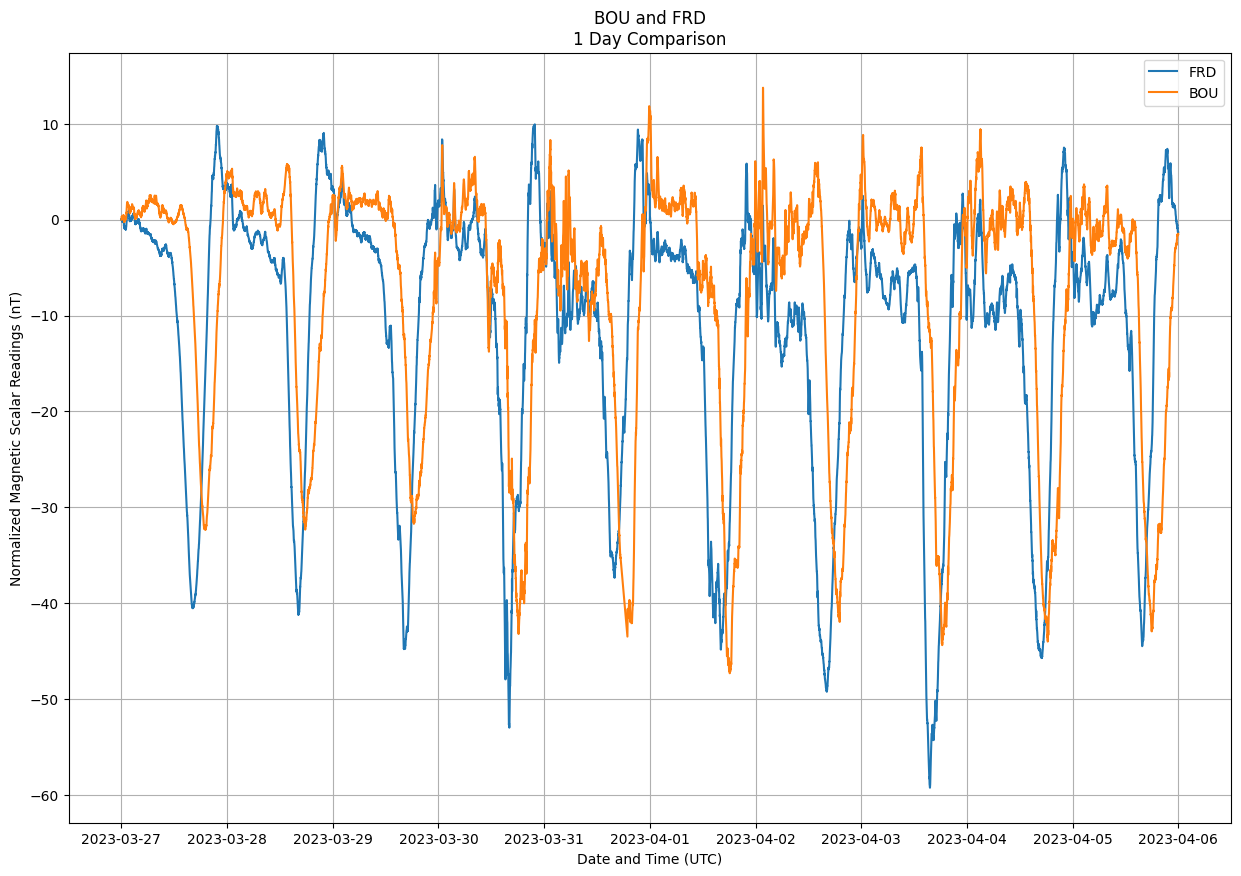

In [3]:
df_dict = pi.loadInterMagData(TEST_DIR, fast_mode = False, second = False)

from_name = arguments['from_data'] # data from 'extended' station
to_name   = arguments['to_data'] # data at location to estimate

from_df = df_dict[from_name]
to_df   = df_dict[to_name]


to_df = pu.reject_outliers(to_df,
                           window_size=200,
                           std_lim=3)

print(from_df)
to_IGRF_f   = np.array(to_df.IGRF_F)[0]
from_IGRF_f = np.array(from_df.IGRF_F)[0]

to_f   = np.array(to_df.F)
from_f = np.array(from_df.F)
    
to_f_no_core   = np.array(to_df.F) - to_IGRF_f
from_f_no_core = np.array(from_df.F) - from_IGRF_f
    
to_t   = np.array(to_df.epoch_sec)
from_t = np.array(from_df.epoch_sec)

plt.figure()
plt.title(from_name + ' and ' + to_name + '\n1 Day Comparison')
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df.datetime, to_f_no_core, label=to_name)
plt.plot(from_df.datetime, from_f_no_core, label=from_name)
plt.legend()
plt.grid()
    
plt.figure()
plt.title(from_name + ' and ' + to_name + '\n1 Day Comparison')
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df.datetime, to_f_no_core - to_f_no_core[0], label=to_name)
plt.plot(from_df.datetime, from_f_no_core - from_f_no_core[0], label=from_name)
plt.legend()
plt.grid()

# print('RMSE:', pu.rmse(to_f_no_core, from_f_no_core[:len(to_f)])) # Extra slicing needed because dimensions don't match as a result of rejecting outliers
# print('RMSE:', pu.rmse(to_f_no_core - to_f_no_core[0], from_f_no_core[:len(to_f)] - from_f_no_core[0])) # Extra slicing needed because dimensions don't match as a result of rejecting outliers

# Simple Longitude Normalization

In [4]:
lon_diff     = from_df.LONG.mean() - to_df.LONG.mean()
lon_t_offset = pd.Timedelta(seconds=lon_diff / (Diurnal.E_ROT_DEG_S))
bou_shift_t  = from_df.epoch_sec + lon_t_offset.total_seconds()

plt.figure()
plt.title('Simplified Longitude Normalization\nFrom ' + from_name + ' to ' + to_name)
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df.datetime, to_f_no_core, label=to_name)
plt.plot(from_df.datetime + lon_t_offset, from_f_no_core, label='{} - Lon Norm\'d'.format(from_name))
plt.legend()
plt.grid()

interp_lpf = interpolate.interp1d(bou_shift_t, from_f_no_core, 'cubic')

interp_mask = np.logical_and(to_t >= bou_shift_t.min(), to_t <= bou_shift_t.max())
interp_t    = to_t[interp_mask] # Clip interpolation times

bou_shift_interp = interp_lpf(interp_t)

print('RMSE:', pu.rmse(to_f_no_core[interp_mask],
                       bou_shift_interp))

RMSE: 252.74458870432994
Error in callback <function flush_figures at 0x7f9604398310> (for post_execute):


KeyboardInterrupt: 

# Frequency-Based Longitude Normalization

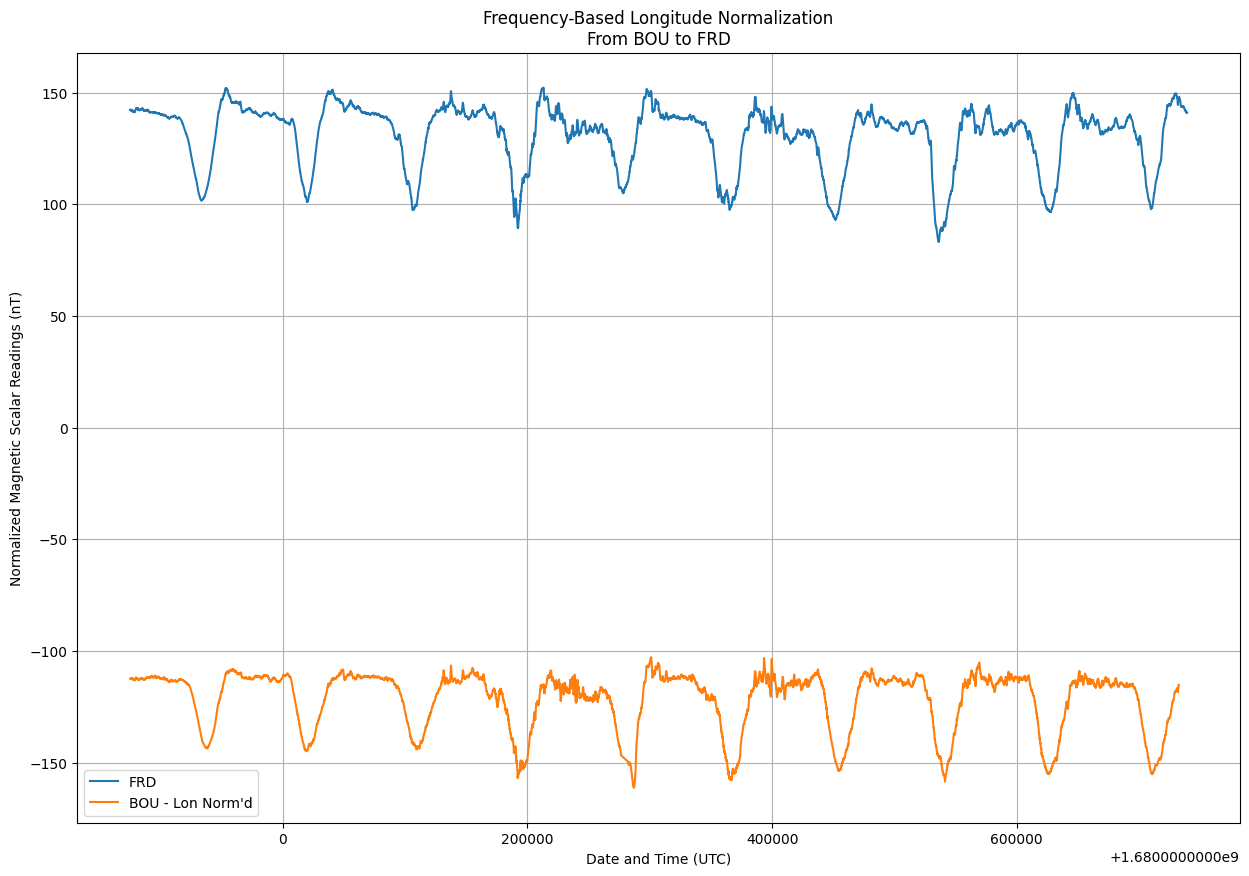

In [5]:
from_combined_t, from_combined_f, _, _ , _ = Diurnal.longitude_norm(from_df, to_df.LONG.mean(), second = False)
from_combined_f_no_core = from_combined_f - from_IGRF_f

plt.figure()
plt.title('Frequency-Based Longitude Normalization\nFrom ' + from_name + ' to ' + to_name)
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df.epoch_sec, to_f_no_core, label=to_name)
plt.plot(from_combined_t, from_combined_f_no_core, label='{} - Lon Norm\'d'.format(from_name))
plt.legend()
plt.grid()

# print('RMSE:', pu.rmse(to_f_no_core[interp_mask],
#                        from_combined_f_no_core[:len(to_f_no_core[interp_mask])]))

# KNN-Optimize Class

In [6]:
class KNN_Optimize:
    # NEW CLASS
    __weight_tried = []
    __rmse_result = []
    __knn_model: KNeighborsRegressor
    __time_data: []
    __from_data: []
    __to_data: []
    __derivative_data: []
    __data_set: []
    __min_max_scaler =  preprocessing.MinMaxScaler()
    __quant_transform = preprocessing.QuantileTransformer(random_state=0)
    __weights = []
    __bounds = ((1, 50),)
    __days_check = []
    __n_neighbors = 0
    
    def __init__(self, time, from_mag, to_mag):
        
        # Store Fitting Data
        self.__time_data = np.fmod(time, 24*3600)
        self.__from_data = from_mag
        self.__to_data = to_mag
        self.__derivative_data = self.time_derivative(from_mag, time)
        
        # Construct Data Set and Normalize
        self.__data_set = np.vstack((self.__time_data, self.__derivative_data, self.__from_data)).T
        
        # Separate Days By Masks and Compute Days that won't be useful for
        # Optimization
        masks, bad_times, skip_days = self.lodcv_index(time)
        print('Skip Days', skip_days)
        
        #skip_days = self.get_anomaly_day_mask(self.__data_set, self.__to_data, masks)
        #print(skip_days)
        
        num_points = len(self.__to_data)
        
        # Compute Quant Transforms for each fold
        transforms = self.get_qt_array(masks)
        
        #print(self.__data_set)
        # Compute Optimal Number of Neighbors
        k, w = self.get_optimal_k(self.__data_set, self.__to_data, masks, bad_times, skip_days, transforms)
        
        
        print("Here with:", k, w)
        # Use K-Fold Validation to Compute Optimal Number)
        self.__n_neighbors = k
        self.__knn_model = KNeighborsRegressor(n_neighbors = self.__n_neighbors, 
                                               weights = 'distance', 
                                               metric = 'manhattan', 
                                               algorithm = 'ball_tree')
        #skip_days = self.days_to_skip(masks)
        print(skip_days)
        
        guess_weight = w
        bound = (max(1,w-5), min(50, w+5))
        # Compute Optimal Weights
        minimizer_kwargs = {"method":"L-BFGS-B",
                            'bounds': self.__bounds, 
                            'args': (self.__data_set, self.__to_data, masks, bad_times, self.__knn_model, transforms, False, skip_days)}
        constraint_weights = basinhopping(self.knn_weights, 
                                          guess_weight,
                                          niter = 5,
                                          stepsize = 2,
                                          T = 50.0,
                                          minimizer_kwargs = minimizer_kwargs)
        print(constraint_weights)
        
#         plt.figure()
#         plt.scatter(self.__weight_tried, self.__rmse_result)
#         plt.xlabel('Applied Derivative Weight')
#         plt.ylabel('RMSE (nT)')
#         plt.title('RMSE as a function Applied Weight')
#         plt.grid()

        #Compute and Fit Quantile Transform Over Whole Data Set
        # Transform Data
        self.__data_set = self.__quant_transform.fit_transform(self.__data_set)
        
        trial = constraint_weights.x
        #trial = 20
        self.__weights = [1, trial, 1]
        
        # Apply Derivative Weights
        self.__data_set[:,1] *= self.__weights[1]
        
        # Fit Model With Optimal Weights
        self.__knn_model.fit(self.__data_set, self.__to_data)
        
    

        
#    @staticmethod
    #@njit(parallel=True, nopython=False)
    def knn_weights(self, weight, X_data, y_data, masks, bad_times, knn_model, transforms, ret_array=False, skip_days = set(), ose = False):
        rmse = 0
        num_days = len(masks)
        num_values = 0
        days_array = []
        for i in range(num_days):
            if i in skip_days:
                continue
            
            # Make Copies of Data Sets And Apply Quantile Transformations
            X_train_copy = transforms[i].transform(deepcopy(X_data[~masks[i],:]))
            y_train_copy = deepcopy(y_data[~masks[i]])
            #get valid points
            points = np.logical_and(masks[i],bad_times)
            X_validate_copy = transforms[i].transform(deepcopy(X_data[points,:]))
            y_validate_copy = deepcopy(y_data[points])
            knn_regression = deepcopy(knn_model)

            deriv_weight = deepcopy(weight)
            #print(deriv_weight)
            try:
                    
                #Apply Weight
                X_train_copy[:,1] *= deriv_weight
                X_validate_copy[:,1] *= deriv_weight

                knn_regression.fit(X_train_copy, y_train_copy)

                prediction = knn_regression.predict(X_validate_copy)
                
                #Handling Case Where points in time are not contiguous
                if(not (points == masks[i]).all()):
                    num_point_breakup = []
                    num_true = 0
                    for j in range(len(points)):
                        if(points[j] == True):
                            num_true += 1
                        elif((points[j] == False) and (num_true != 0)):
                            num_point_breakup.append(num_true)
                            num_true = 0
                    
                    # Adding the last one
                    if(num_true != 0):
                        num_point_breakup.append(num_true)
                    
                    if(len(num_point_breakup)>1):
                        temp_predict = []
                        start = 0
                        num_breakup = len(num_point_breakup)
                        
                        #Filter Each Block Independently
                        for k in range(num_breakup):
                            end = start+ num_point_breakup[k]
                            temp_predict.extend(filt.lpf(prediction[start:end], 1/(24*100), 1/60))
                            start += points_in_breakup
                        
                        prediction = temp_predict
                    
                    else:
                        #Continguous Time Block
                        prediction = filt.lpf(prediction, 1/(24*100), 1/60)
                else:
                    # Continguous Time Block
                    prediction = filt.lpf(prediction, 1/(24*100), 1/60)
                
                trial_rmse = pu.rmse(prediction, y_validate_copy)
                #print(trial_rmse)
                # Add Contribution To RMSE
                rmse += trial_rmse*sum(points)
                num_values += sum(points) # Number of points being checked
                if(ret_array == True or ose==True):
                    days_array.append(trial_rmse)

                # Clear Memory
                X_train_copy = None
                y_train_copy = None
                X_validate_copy = None
                y_validate_copy = None
                knn_regression = None
                
                #print(i, deriv_weight, trial_rmse)

            except:
                do_nothing = 0
        
        rmse /= num_values
        
        #print(rmse)
        self.__weight_tried.append(weight)
        self.__rmse_result.append(rmse)
        if(ret_array == True):
            self.__days_check.append(days_array)
        
        if(ose == True):
            std_err = np.std(days_array, ddof = 1)/np.sqrt(len(days_array))
            return rmse, std_err
        
        
        return rmse
    
    def predict(self, time, from_mag):
        derivative = self.time_derivative(from_mag, time)
        tod = np.fmod(time, 24*3600)
        
        #Compute and Normalize Data
        data = np.vstack((tod, derivative, from_mag)).T
        data = self.__quant_transform.transform(data)
        
        data[:,1] *= self.__weights[1] # Add Alpha Weight
        
        # Filter And Return Prediction
        return filt.lpf(self.__knn_model.predict(data), 1/(24*100), 1/60)
        
    def get_optimal_k(self, X, y, days_mask, bad_days, skip_days, transforms):
        k_range = range(1,30)
        rmse_matrix = []
        weights = np.linspace(1,50,16)
        for k in k_range:
            #print(k)
            knn_regression = KNeighborsRegressor(n_neighbors = k, 
                                               weights = 'distance', 
                                               metric = 'manhattan', 
                                               algorithm = 'ball_tree')
            #print(k)
            rmse_row = []
            for w in weights:
                #print(days_mask)
                rmse = self.knn_weights(w, X, y, days_mask, bad_days, knn_regression, transforms, skip_days = skip_days)
                rmse_row.append(rmse)
                #print('\t', w)
            
            #print(rmse_row)
            #print(k)
            rmse_matrix.append(rmse_row)
            
        
        #print('here')
        num_k = len(rmse_matrix)
        min_k_values = []
        min_indices = []
        for i in range(num_k):
            k_array = rmse_matrix[i]
            min_index = np.argmin(k_array)
            min_k_values.append(k_array[min_index])
            min_indices.append(min_index)
        
        
        # Get Minimum Values
        min_k_index = np.argmin(min_k_values)
        opt_k = k_range[min_k_index]
        opt_weight = weights[min_indices[min_k_index]]
        
        print(opt_k, opt_weight)
        knn_regression = KNeighborsRegressor(n_neighbors = opt_k, 
                                               weights = 'distance', 
                                               metric = 'manhattan', 
                                               algorithm = 'ball_tree')
        rmse, std_err = self.knn_weights(opt_weight, X, y, days_mask, bad_days, knn_regression, transforms, skip_days = skip_days, ose=True)
        #print(std_err)
        #print(min_k_values)
        
        return opt_k, opt_weight
    
    def lodcv_index(self, epoch_time):
        '''
        Leave one day cross validation 
        (similar to leave one out cross validation (LOOCV))        
        '''
        min_time = min(epoch_time)
        max_time = max(epoch_time)
        print(min_time, max_time)
        
        min_t = datetime.datetime.fromtimestamp(min_time)
        max_t = datetime.datetime.fromtimestamp(max_time)
        
        min_DOY = int(min_t.strftime('%j'))
        max_DOY = int(max_t.strftime('%j'))
        
        print(min_DOY+1, max_DOY+1)
        
        compiled_df = pd.DataFrame()
    
        # Handle Timings
        compiled_df['epoch_sec'] = epoch_time
        compiled_df['datetime'] = pd.to_datetime(compiled_df['epoch_sec'], unit='s')
        DOY_array = np.array(compiled_df['datetime'].dt.day_of_year)
        
        masks = []
        min_time_date, max_time_date  = self.get_start_end_date(epoch_time)
        print(min_time_date, max_time_date)
        df = self.get_KP_data(min_time_date, max_time_date)
        #kp_values = self.map_kp_data(epoch_time, df, False)
        kp_bool = self.map_kp_data(epoch_time, df)
        
        # TODO CREATE CHECKER TO ENSURE NON_LEAP YEAR OTHERWISE MAKE %366
        print(min_DOY, max_DOY)
        start_date = (min_DOY+1)
        end_date = (max_DOY+1)
        # make sure end_date > start_date again check leap year to use 366 (Do Later)
        if end_date < start_date:
            end_date += 365
            
        # print(start_date, end_date)
        for day in range(start_date, end_date):
            masks.append(DOY_array == (day)%365)
            
        days_skip = set()    
        num_days = len(masks)
        for i in range(num_days):
            #print(np.sum(masks[i]))
            #print(np.sum(kp_bool))
            if np.sum(np.logical_and(masks[i],kp_bool)) == 0:
                #print('here')
                days_skip.add(i)
        
        #print(masks)
        return masks, kp_bool, days_skip
    
    def time_derivative(self, mag_array, time_array):
        n = len(mag_array)
        dxdt = []
        # Handle First Point With Forward Approximator
        dxdt.append((mag_array[1]-mag_array[0])/(time_array[1]-time_array[0]))

        # Handle Middle Points with Centered Approximator
        i = 1
        while i < n-1:
            dxdt.append((mag_array[i+1] - mag_array[i-1])/(time_array[i+1] - time_array[i-1]))
            i += 1

        # Handle Last Point  With Backward Approximator
        dxdt.append((mag_array[i]-mag_array[i-1])/(time_array[i]-time_array[i-1]))
        return np.array(dxdt)

    def get_KP_data(self, start_date, end_date):
        df = pd.DataFrame()
        link = 'https://kp.gfz-potsdam.de/kpdata?startdate=' + start_date + '&enddate=' + end_date + '&format=kp2#kpdatadownload-143'
        
        ctx = ssl.create_default_context()
        ctx.check_hostname = False
        ctx.verify_mode = ssl.CERT_NONE
        data = StringIO(urllib.request.urlopen(link, context=ctx).read().decode('utf-8'))
        
        
        df[['Year', 'Month', 'Day', 'Start-Time', 'Mid-Time', 'Days_Since_Start_UT_Day', 'Days_Since_Mid_UT_Day', 'Kp', 'ap', 'Definitive']] = pd.read_csv(data, sep ="\s+") 
    
        y_arr = list(df['Year'])
        m_arr = list(df['Month'])
        d_arr = list(df['Day'])

        num_points = len(y_arr)

        hour_float_arr = list(df['Start-Time'])
        h_arr = list(map(int,hour_float_arr))

        min_float_arr = [(hour_float_arr[i] - h_arr[i])*60 for i in range(num_points)]
        min_arr = list(map(int, min_float_arr))

        sec_float_arr = [(min_float_arr[i] - min_arr[i])*60 for i in range(num_points)]
        sec_arr = list(map(int, sec_float_arr))

        num_points = len(y_arr)
        datetime_arr = [datetime.datetime(y_arr[i],m_arr[i],d_arr[i],h_arr[i],min_arr[i],sec_arr[i],0) for i in range(num_points)]


        df['datetime'] = datetime_arr
        df['epoch_sec'] = (df['datetime'] - pd.Timestamp('1970-01-01')).dt.total_seconds()

        return df


    def map_kp_data(self, time_series, kp_df, quiet = True):
        time_to_kp = interpolate.interp1d(list(kp_df['epoch_sec']),list(kp_df['Kp']),kind='previous')
        kp_array = time_to_kp(time_series)

        if quiet == False:
            return kp_array

        num_points = len(kp_array)
        mag_storm_thresh = 4
        kp_bool = np.empty(num_points, dtype='bool')

        for i in range(num_points):
            kp_bool[i] = ~(kp_array[i] >= mag_storm_thresh)

        return kp_bool


    def get_start_end_date(self, time):
        min_date = datetime.datetime.fromtimestamp(min(time))
        min_date -= datetime.timedelta(days=1)
        max_date = datetime.datetime.fromtimestamp(max(time))
        max_date += datetime.timedelta(days=1)

        min_date_str = min_date.strftime('%Y-%m-%d')
        max_date_str = max_date.strftime('%Y-%m-%d')

        return min_date_str, max_date_str
    
    def get_qt_array(self, masks):
        num_days = len(masks)
        quant_transforms = []
        for i in range(num_days):
            quant = preprocessing.QuantileTransformer(random_state=0)
            quant.fit(self.__data_set[~masks[i],:])
            quant_transforms.append(quant)
        return quant_transforms
    
    def get_params(self):
        return self.__n_neighbors, np.asscalar(self.__weights[1])

# Utility Methods

In [7]:
def down_sample(array, fs=1/60):
    array_fft = np.fft.rfft(array)[0:int(len(array)*fs)]*(2*fs)
    return np.fft.irfft(array_fft) 

def get_KP_data(start_date, end_date):
    df = pd.DataFrame()
    link = 'https://kp.gfz-potsdam.de/kpdata?startdate=' + start_date + '&enddate=' + end_date + '&format=kp2#kpdatadownload-143'

    ctx = ssl.create_default_context()
    ctx.check_hostname = False
    ctx.verify_mode = ssl.CERT_NONE
    data = StringIO(urllib.request.urlopen(link, context=ctx).read().decode('utf-8'))


    df[['Year', 'Month', 'Day', 'Start-Time', 'Mid-Time', 'Days_Since_Start_UT_Day', 'Days_Since_Mid_UT_Day', 'Kp', 'ap', 'Definitive']] = pd.read_csv(data, sep ="\s+") 

    y_arr = list(df['Year'])
    m_arr = list(df['Month'])
    d_arr = list(df['Day'])

    num_points = len(y_arr)

    hour_float_arr = list(df['Start-Time'])
    h_arr = list(map(int,hour_float_arr))

    min_float_arr = [(hour_float_arr[i] - h_arr[i])*60 for i in range(num_points)]
    min_arr = list(map(int, min_float_arr))

    sec_float_arr = [(min_float_arr[i] - min_arr[i])*60 for i in range(num_points)]
    sec_arr = list(map(int, sec_float_arr))

    num_points = len(y_arr)
    datetime_arr = [datetime.datetime(y_arr[i],m_arr[i],d_arr[i],h_arr[i],min_arr[i],sec_arr[i],0) for i in range(num_points)]


    df['datetime'] = datetime_arr
    df['epoch_sec'] = (df['datetime'] - pd.Timestamp('1970-01-01')).dt.total_seconds()

    return df


def map_kp_data(time_series, kp_df, quiet = True):
    time_to_kp = interpolate.interp1d(list(kp_df['epoch_sec']),list(kp_df['Kp']),kind='previous')
    kp_array = time_to_kp(time_series)

    if quiet == False:
        return kp_array

    num_points = len(kp_array)
    mag_storm_thresh = 4
    kp_bool = np.empty(num_points, dtype='bool')

    for i in range(num_points):
        kp_bool[i] = ~(kp_array[i] >= mag_storm_thresh)

    return kp_bool


def get_start_end_date(time):
    min_date = datetime.datetime.fromtimestamp(min(time))
    min_date -= datetime.timedelta(days=1)
    max_date = datetime.datetime.fromtimestamp(max(time))
    max_date += datetime.timedelta(days=1)

    min_date_str = min_date.strftime('%Y-%m-%d')
    max_date_str = max_date.strftime('%Y-%m-%d')

    return min_date_str, max_date_str

def minmax(array):
    return [min(array),max(array)]


def different_time_rmse(truth_time, truth_mag, predict_time, predict_mag, break_up=None):
    #ensure np array
    truth_time = np.array(truth_time)
    predict_time = np.array(predict_time)
    
    #get overlap range 
    minmax_truth_time = minmax(truth_time)
    minmax_predict_time = minmax(predict_time)

    min_t = max(minmax_truth_time[0], minmax_predict_time[0])
    max_t = min(minmax_truth_time[1], minmax_predict_time[1])
    
    #get mask for overlap range of truth_time 
    time_mask = np.logical_and(truth_time >= min_t, truth_time <= max_t)

    #interpolation model for predict_time, predict_mag
    interp_predict = interpolate.interp1d(predict_time, predict_mag, 'cubic', fill_value='extrapolate')
    
    #Interpolate At Specific Times
    predict_mag_interp = interp_predict(truth_time[time_mask])
    truth_truncated = truth_mag[time_mask]
    
    if break_up is None:
        return pu.rmse(truth_truncated, predict_mag_interp)
    
    rmse_array = [0,0]
    
    if break_up == 'Kp':
        epoch_overlap = truth_time[time_mask]
        start_date, end_date = get_start_end_date(epoch_overlap)
        kp_df = get_KP_data(start_date, end_date)
        kp_mask = map_kp_data(epoch_overlap, kp_df)
        #Quiet Kp
        rmse_array[0] = pu.rmse(truth_truncated[kp_mask], predict_mag_interp[kp_mask])
        
        #High Space Weather Analysis
        try:
            rmse_array[1] = pu.rmse(truth_truncated[~kp_mask], predict_mag_interp[~kp_mask])
        except:
            rmse_array[1] = float("nan")
        return rmse_array
    
    rmse_array = []
    if break_up == 'day':
        epoch_overlap = truth_time[time_mask]
        max_sec = 24*3600
        days = np.fmod(epoch_overlap, max_sec)
        max_index = len(days) -1
        break_up_array = [0]
        i = 0
        while i < max_index:
            if days[i+1] < days[i]:
                break_up_array.append(i)
                break_up_array.append(i+1)
            i += 1
        break_up_array.append(max_index)
        
        divisions = len(break_up_array)
        j = 0
        while j < divisions:
            min_range = break_up_array[j]
            max_range = break_up_array[j+1]
            rmse_array.append(pu.rmse(truth_truncated[min_range:max_range],predict_mag_interp[min_range:max_range]))
            j += 2
        return rmse_array
        
    length = len(predict_mag_interp)
    for i in range(break_up):
        min_range = int(i*length/break_up)
        max_range = int((i+1)*length/break_up)
        rmse_array.append(pu.rmse(truth_truncated[min_range:max_range],predict_mag_interp[min_range:max_range]))
    
    return rmse_array

# Find Optimal Scale and Offset Parameters

Optimal scale: 0.9174673739855561
Optimal offset: 242.62461759859167
1679875260.0 1680732420.0
86 96
2023-03-25 2023-04-06
85 95
Skip Days set()
26 4.266666666666667
Here with: 26 4.266666666666667
set()
                        fun: 4.94067644863594
 lowest_optimization_result:       fun: 4.94067644863594
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00062714])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 184
      nit: 7
     njev: 92
   status: 0
  success: True
        x: array([4.19027942])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 2
                       nfev: 526
                        nit: 5
                       njev: 263
                          x: array([4.19027942])
RMSE linear: 7.376640446404858
RMSE knn: 3.76484174728359
RMSE linear: [7.06791369905086, 6.057869672870937, 6.534358046086428, 6.508912537157702, 7.600492037474715, 

/tmp/ipykernel_4453/605556344.py:406: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return self.__n_neighbors, np.asscalar(self.__weights[1])


1

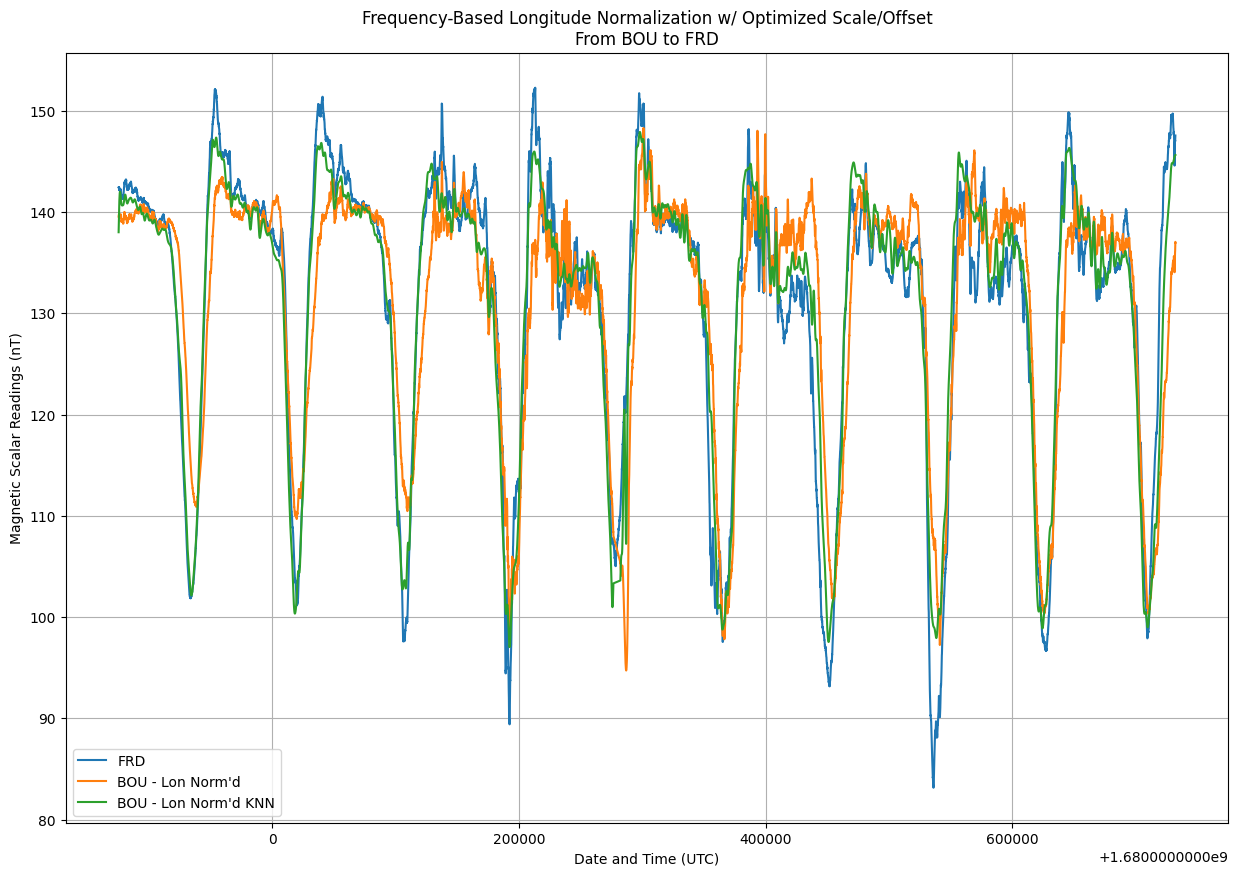

In [8]:
# Linear Regression Method    
interp_combined = interpolate.interp1d(from_combined_t, from_combined_f_no_core, 'cubic')

interp_mask = np.logical_and(to_t >= from_combined_t.min(), to_t <= from_combined_t.max())
interp_t    = to_t[interp_mask] # Clip interpolation times

from_combined_interp = interp_combined(interp_t)

offset, scale = Diurnal.calibrate([0, 1], from_combined_interp, to_f_no_core[interp_mask])
from_combined_opt_f = Diurnal.apply_cal([offset, scale], from_combined_f_no_core)

print('Optimal scale:',  scale)
print('Optimal offset:', offset)


n_neighbors = 9

# create and fit model
knn = KNN_Optimize(interp_t, from_combined_interp, to_f_no_core[interp_mask])
prediction = knn.predict(from_combined_t, from_combined_f_no_core)

plt.figure()
plt.title('Frequency-Based Longitude Normalization w/ Optimized Scale/Offset\nFrom ' + from_name + ' to ' + to_name)
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Magnetic Scalar Readings (nT)')
plt.plot(to_df.epoch_sec[interp_mask], to_f_no_core[interp_mask], label=to_name)
plt.plot(from_combined_t, from_combined_opt_f, label='{} - Lon Norm\'d'.format(from_name))
plt.plot(from_combined_t, prediction, label='{} - Lon Norm\'d KNN'.format(from_name))
plt.legend()
plt.grid()

# Calculate Root Mean Square Error
rmse_linear= different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,from_combined_opt_f)
rmse_knn= different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,prediction)

rmse_linear_broken= different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,from_combined_opt_f,'day')
rmse_knn_broken= different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,prediction,'day')

rmse_kp_linear = different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,from_combined_opt_f,'Kp')
rmse_kp_knn = different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,prediction,'Kp')

print('RMSE linear:', rmse_linear)
print('RMSE knn:', rmse_knn)

print('RMSE linear:', rmse_linear_broken)
print('RMSE knn:', rmse_knn_broken)

print('RMSE linear Kp [<4, >=4]:', rmse_kp_linear)
print('RMSE knn: Kp [<4, >=4]', rmse_kp_knn)

k, w = knn.get_params()

first_data_list = [from_name, to_name, start_tra, end_tra, offset, scale, k, w, rmse_linear, rmse_knn]
first_data_list.extend(rmse_linear_broken)
first_data_list.extend(rmse_knn_broken)
first_data_list.extend(rmse_kp_linear)
first_data_list.extend(rmse_kp_knn)
out_file.write(','.join(map(str,first_data_list)))
out_file.write(',')


# Test Optimal Parameters for Next Day's Data

Loaded bou20230410qmin.min
Loaded frd20230410qmin.min
Loaded bou20230411qmin.min
Loaded frd20230411qmin.min
Loaded frd20230412qmin.min
Loaded bou20230412qmin.min
Loaded frd20230408qmin.min
Loaded bou20230408qmin.min
Loaded bou20230406qmin.min
Loaded frd20230406qmin.min
Loaded frd20230407qmin.min
Loaded bou20230407qmin.min
Loaded frd20230409qmin.min
Loaded bou20230409qmin.min


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 144.96it/s]


[242.62461759859167, 0.9174673739855561]
RMSE linear: 5.7996201150357845
RMSE knn: 3.8977988258924703


/home/antuser/anaconda3/envs/envp39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/antuser/anaconda3/envs/envp39/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


RMSE linear: [2.523293949840492, 7.900003950121954, 4.279671135256633, 4.0843976813197775, 7.585950228310856, 7.232376945001439, 4.349674334259736]
RMSE knn: [3.401182316798706, 4.558542902105397, 2.772460350365027, 3.547489813307243, 4.330471348604189, 4.107142100027465, 4.252552925355405]
RMSE linear Kp [<4, >=4]: [5.7996201150357845, nan]
RMSE knn: Kp [<4, >=4] [3.8977988258924703, nan]


ValueError: I/O operation on closed file.

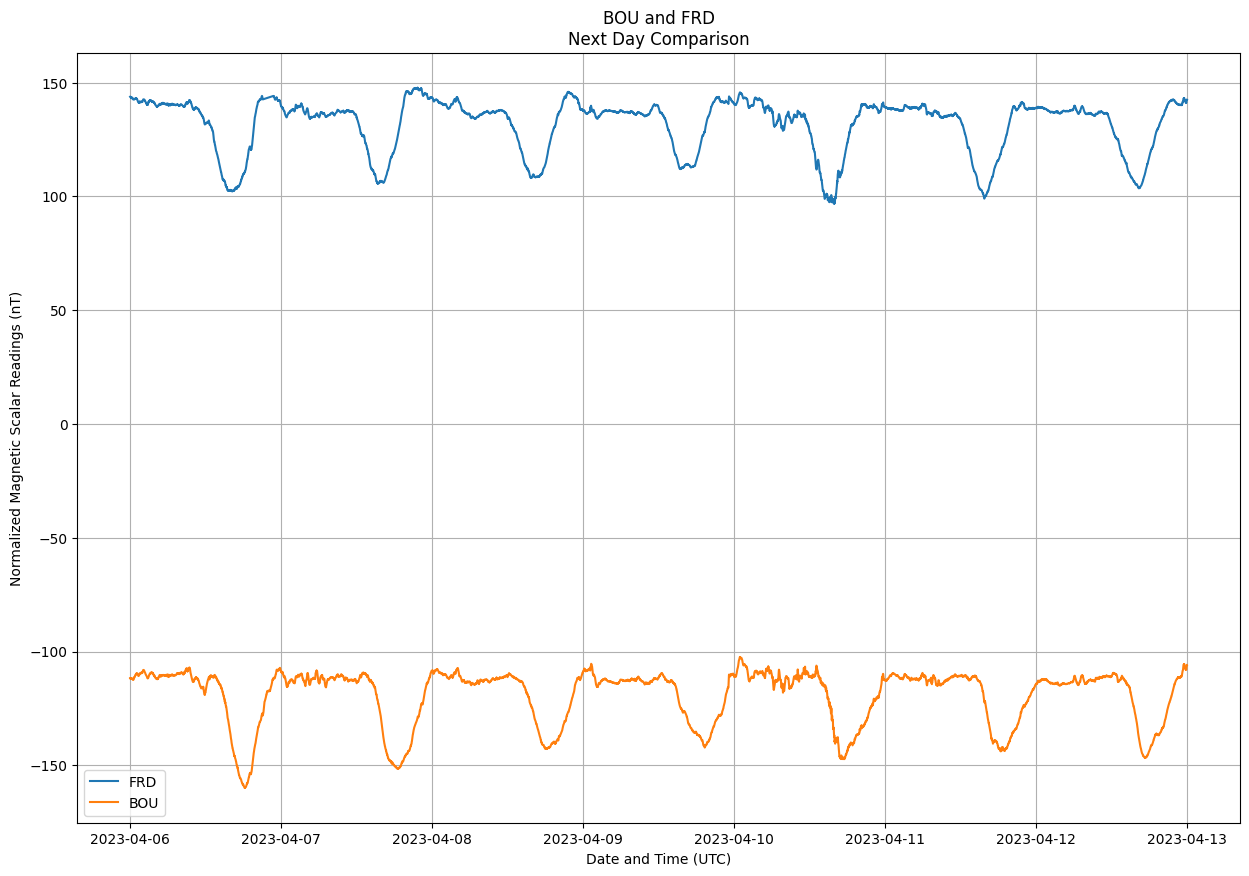

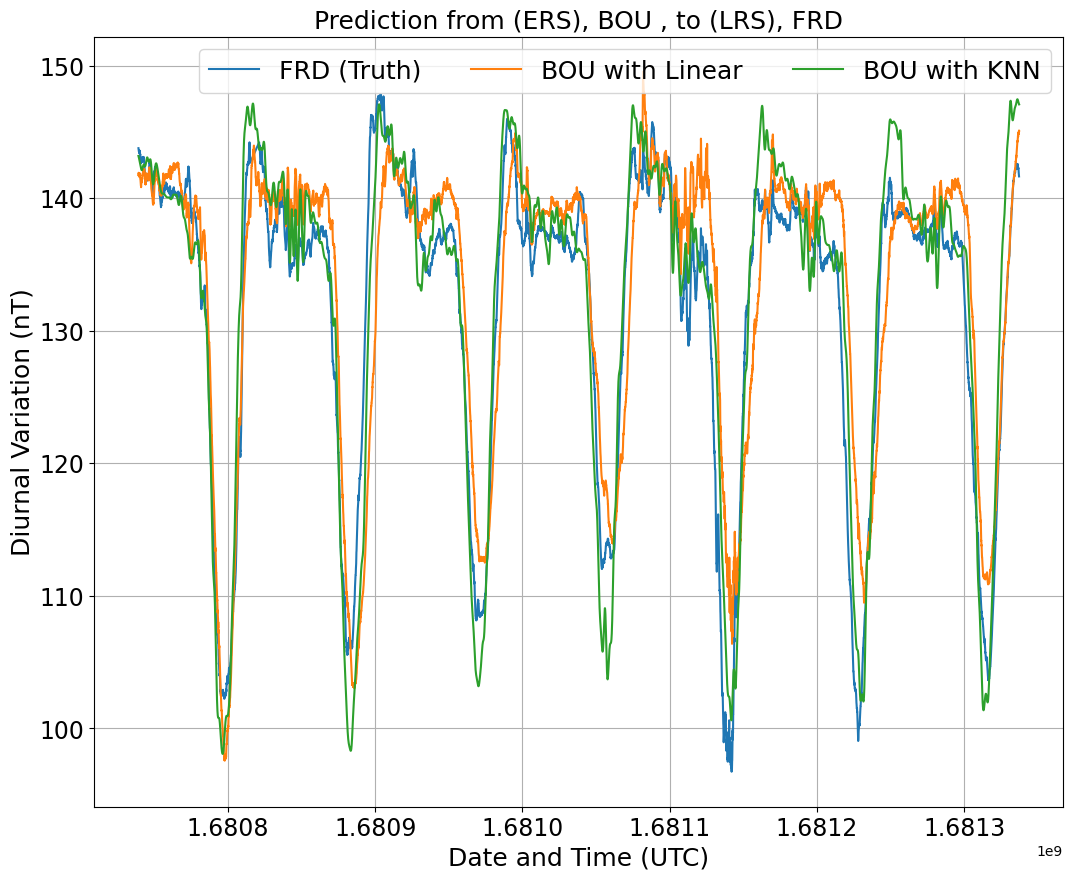

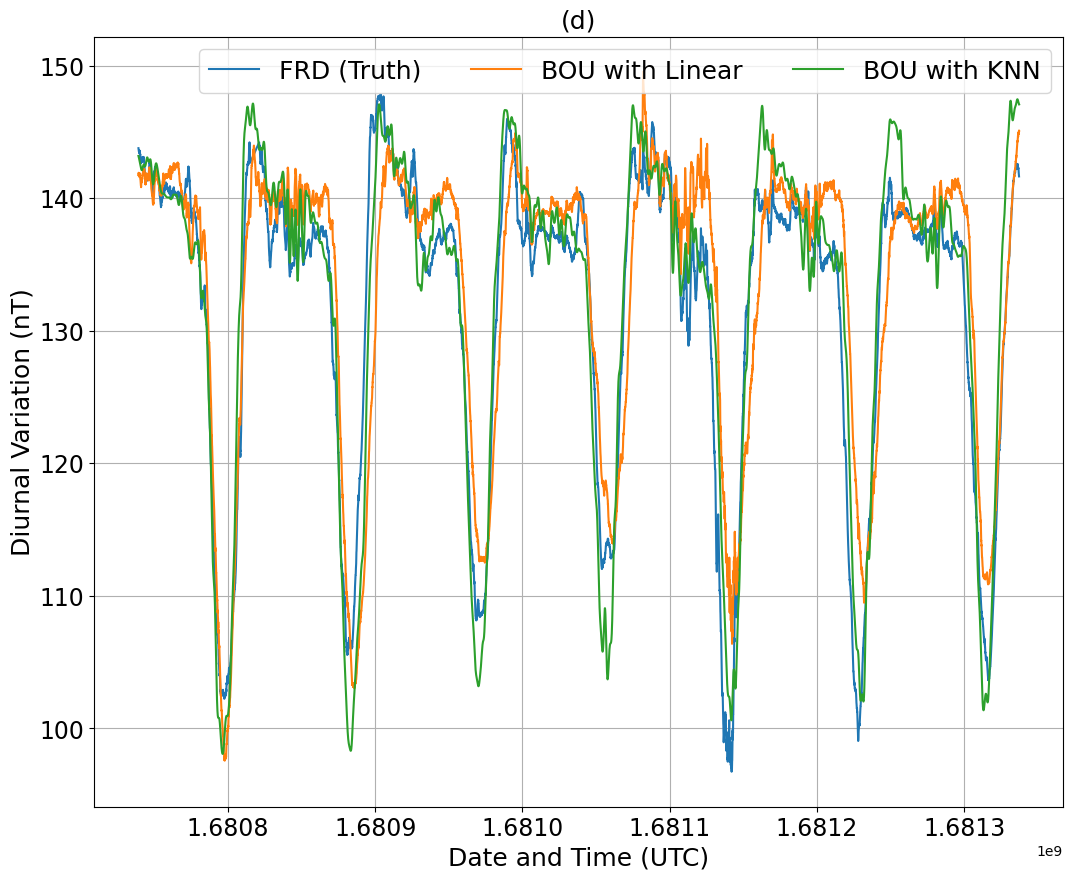

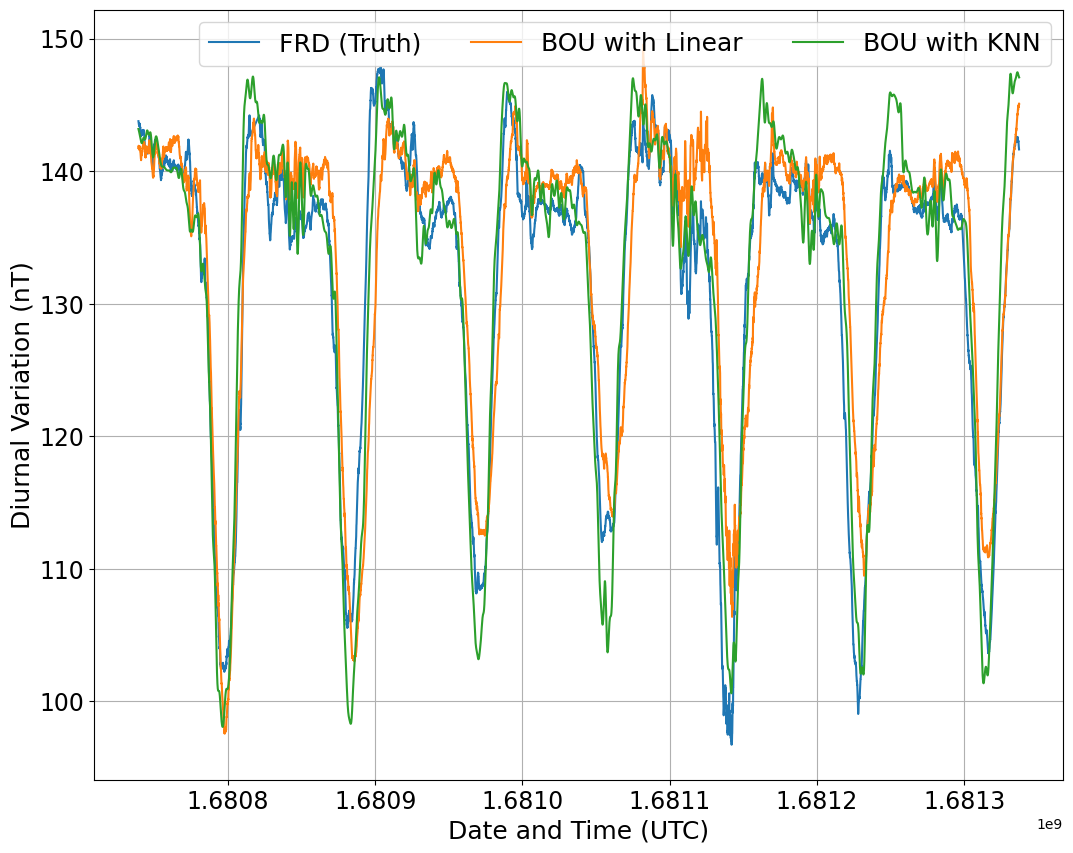

In [22]:
df_dict = pi.loadInterMagData(EXAM_DIR, second=False)

from_name = arguments['from_data'] # data from 'extended' station
to_name   = arguments['to_data'] # data at location to estimate

from_df = df_dict[from_name]
to_df   = df_dict[to_name]

to_df = pu.reject_outliers(to_df,
                           window_size=2000,
                           std_lim=3)

to_IGRF_f   = np.array(to_df.IGRF_F)[0]
from_IGRF_f = np.array(from_df.IGRF_F)[0]

to_f   = np.array(to_df.F)
from_f = np.array(from_df.F)
    
to_f_no_core   = np.array(to_df.F) - to_IGRF_f
from_f_no_core = np.array(from_df.F) - from_IGRF_f
    
to_t   = np.array(to_df.epoch_sec)
from_t = np.array(from_df.epoch_sec)


plt.figure()
plt.title(from_name + ' and ' + to_name + '\nNext Day Comparison')
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df.datetime, to_f_no_core, label=to_name)
plt.plot(from_df.datetime, from_f_no_core, label=from_name)
plt.legend()
plt.grid()


from_combined_t, from_combined_f, _, _ , _ = Diurnal.longitude_norm(from_df, to_df.LONG.mean(), second=False)
from_combined_f_no_core = from_combined_f - from_IGRF_f


interp_combined = interpolate.interp1d(from_combined_t, from_combined_f_no_core, 'cubic')

interp_mask = np.logical_and(to_t >= from_combined_t.min(), to_t <= from_combined_t.max())
interp_t    = to_t[interp_mask] # Clip interpolation times

from_combined_interp = interp_combined(interp_t)

print([offset, scale])
from_combined_opt_f = Diurnal.apply_cal([offset, scale], from_combined_f_no_core)


prediction = knn.predict(from_combined_t, from_combined_f_no_core)

font = 18
plt.figure(figsize = (12.5,10))
plt.title('Prediction from (ERS), ' + from_name  +  ' , to (LRS), ' + to_name, fontsize = font)
plt.xlabel('Date and Time (UTC)', fontsize = font)
plt.ylabel('Diurnal Variation (nT)', fontsize = font)
plt.plot(to_df.epoch_sec[interp_mask], to_f_no_core[interp_mask], label='{} (Truth)'.format(to_name))
plt.plot(from_combined_t, from_combined_opt_f, label='{} with Linear'.format(from_name))
plt.plot(from_combined_t, prediction, label='{} with KNN'.format(from_name))
plt.legend(fontsize = font, ncol=3)
plt.xticks(fontsize = font-1)
plt.yticks(fontsize = font-1)
plt.grid()

plt.figure(figsize = (12.5,10))
plt.title('(d)', fontsize = font)
plt.xlabel('Date and Time (UTC)', fontsize = font)
plt.ylabel('Diurnal Variation (nT)', fontsize = font)
plt.plot(to_df.epoch_sec[interp_mask], to_f_no_core[interp_mask], label='{} (Truth)'.format(to_name))
plt.plot(from_combined_t, from_combined_opt_f, label='{} with Linear'.format(from_name))
plt.plot(from_combined_t, prediction, label='{} with KNN'.format(from_name))
plt.legend(fontsize = font, ncol = 3)
plt.xticks(fontsize = font-1)
plt.yticks(fontsize = font-1)
plt.grid()

plt.figure(figsize = (12.5,10))
plt.xlabel('Date and Time (UTC)', fontsize = font)
plt.ylabel('Diurnal Variation (nT)', fontsize = font)
plt.plot(to_df.epoch_sec[interp_mask], to_f_no_core[interp_mask], label='{} (Truth)'.format(to_name))
plt.plot(from_combined_t, from_combined_opt_f, label='{} with Linear'.format(from_name))
plt.plot(from_combined_t, prediction, label='{} with KNN'.format(from_name))
plt.legend(fontsize = font, ncol = 3)
plt.xticks(fontsize = font-1)
plt.yticks(fontsize = font-1)
plt.grid()

# Calculate Root Mean Square Error
next_rmse_linear= different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,from_combined_opt_f)
next_rmse_knn= different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,prediction)

print('RMSE linear:', next_rmse_linear)
print('RMSE knn:', next_rmse_knn)


next_rmse_linear_broken= different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,from_combined_opt_f,'day')
next_rmse_knn_broken= different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,prediction,'day')

next_rmse_kp_linear = different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,from_combined_opt_f,'Kp')
next_rmse_kp_knn = different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,prediction,'Kp')

print('RMSE linear:', next_rmse_linear_broken)
print('RMSE knn:', next_rmse_knn_broken)

print('RMSE linear Kp [<4, >=4]:', next_rmse_kp_linear)
print('RMSE knn: Kp [<4, >=4]', next_rmse_kp_knn)

second_data_list = [start_tst, end_tst, next_rmse_linear, next_rmse_knn]
second_data_list.extend(next_rmse_linear_broken)
second_data_list.extend(next_rmse_knn_broken)
second_data_list.extend(next_rmse_kp_linear)
second_data_list.extend(next_rmse_kp_knn)
out_file.write(','.join(map(str,second_data_list)))
out_file.write('\n')
out_file.close()